In [1]:
!pip install pybullet

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

import random
import pybullet as pb
import pybullet_data
import numpy as np

pybullet build time: May  8 2021 05:50:53


In [3]:
physicsClient = pb.connect(pb.DIRECT)
pb.setAdditionalSearchPath(pybullet_data.getDataPath())

In [4]:
import pkgutil
egl = pkgutil.get_loader('eglRenderer')
pb.loadPlugin(egl.get_filename(), "_eglRendererPlugin")

Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro M2000M/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 470.63.01
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 470.63.01
Vendor = NVIDIA Corporation
Renderer = Quadro M2000M/PCIe/SSE2


4

In [5]:
def get_camera_transforms(position, target):
    projectionMatrix = pb.computeProjectionMatrixFOV(fov=45.0, aspect=1.0, nearVal=0.1, farVal=100.0)

    viewMatrix = pb.computeViewMatrix(
        cameraEyePosition=position,
        cameraTargetPosition=target,
        cameraUpVector=[0, 0, 1])
    return viewMatrix, projectionMatrix

def reset_env():
    pb.resetSimulation()
    pb.configureDebugVisualizer(pb.COV_ENABLE_GUI, 1)
    pb.setGravity(0, 0, -9.8)
    
    plane = pb.loadURDF("plane.urdf", basePosition=[0, 0, -0.5], useFixedBase=True, globalScaling=2)
    table = pb.loadURDF("table/table.urdf", basePosition=[0, 0, -6.3], useFixedBase=True, globalScaling=10)

In [6]:
def create_shape(shape_type, mass, position, half_extends=0, radius=0, mesh_scale=None, orientation=None, color=None):
    if not orientation:
        orientation = [0, 0, 0]

    if isinstance(shape_type, str):
        if not mesh_scale:
            mesh_scale = [1, 1, 1]
        vId = pb.createVisualShape(shapeType=pb.GEOM_MESH, fileName=shape_type, meshScale=mesh_scale, rgbaColor=color)
        cId = pb.createCollisionShape(shapeType=pb.GEOM_MESH, fileName=shape_type, meshScale=mesh_scale)    
    else:
        vId = pb.createVisualShape(shapeType=shape_type, halfExtents=half_extends, radius=radius, rgbaColor=color)
        cId = pb.createCollisionShape(shapeType=shape_type, halfExtents=half_extends, radius=radius)    
    return pb.createMultiBody(baseMass=mass, baseCollisionShapeIndex=cId, baseVisualShapeIndex=vId, basePosition=position, baseOrientation=pb.getQuaternionFromEuler(orientation))

In [7]:
pyramid_obj = """g Object001

v  -0.5  -0.5  -0.5
v  0.5  -0.5  -0.5
v  0.5  0.5  -0.5
v  -0.5  0.5  -0.5
v  0  0  0.5

f  4  2  1
f  3  2  4
f  5  1  2
f  4  1  5
f  3  4  5
f  5  2  3
"""

with open("pyramid.obj", mode="wt") as f:
    f.write(pyramid_obj)

In [8]:
reset_env()

b1 = create_shape(pb.GEOM_BOX, 1, [0, 0, 0.5], half_extends=[0.5, 0.5, 0.5], color=[1, 0, 0, 1])
b2 = create_shape(pb.GEOM_SPHERE, 1, [0.6, 2, 0.5], radius=0.5, color=[1, 1, 0, 1])
b3 = create_shape("pyramid.obj", 1, [-2, 2, 0.5], mesh_scale=[1.5, 1.5, 1.5], color=[1, 0, 1, 1])

cam_view_m, cam_proj_m = get_camera_transforms([2, -6, 12], [0, -1, 0])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.axis('off')
frames = []

for i in range(100):
    for _ in range(4):
        pb.stepSimulation()
    _, _, rgbImg, _, _ = pb.getCameraImage(320, 320, cam_view_m, cam_view_m, lightDirection=[-1, -1, 10])
    frame = ax.imshow(rgbImg, animated=True)
    frames.append([frame])    

anim = ArtistAnimation(fig, frames, interval=16.6, blit=True, repeat=True)
HTML(anim.to_html5_video())

In [10]:
for _ in range(300):
    pb.stepSimulation()

ven = NVIDIA Corporation


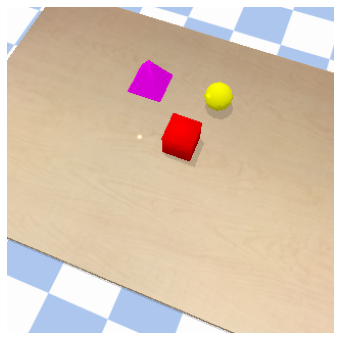

In [9]:
cam_view_m, cam_proj_m = get_camera_transforms([2, -6, 12], [0, -1, 0])

width, height, rgbImg, depthImg, segImg = pb.getCameraImage(320, 320, cam_view_m, cam_proj_m, lightDirection=[-2, 1, 10])
plt.figure(figsize=(6, 6))
plt.imshow(rgbImg)
plt.axis('off')
plt.show()

In [10]:
import re
import dataclasses
from dataclasses import dataclass
from enum import IntEnum

class AtomColor(IntEnum): 
    NO_COLOR = 0   
    BLUE = 1
    GREEN = 2
    CYAN = 3 
    RED = 4
    PURPLE = 5
    YELLOW = 6
    WHITE = 7

    def nice_name(self):
        return self.name.lower() if self else ""

    def to_rgba(self): 
        return tuple(float(ch) for ch in np.binary_repr(self, width=3)) + tuple([1.0])

class AtomObject(IntEnum):
    ACTOR = 0
    TABLE = 1
    CUBE = 2
    SPHERE = 3
    PYRAMID = 4

    def nice_name(self):
        return self.name.lower()

class AtomRelation(IntEnum):    
    ON = 0
    NEAR = 1    
    ON_LEFT_SIDE_OF = 2
    ON_RIGHT_SIDE_OF = 3
    ON_NEAR_SIDE_OF = 4
    ON_FAR_SIDE_OF = 5
    IN_CENTER_OF = 6

    def nice_name(self):
        return self.name.lower()


def to_one_hot(e: IntEnum):
    return np.eye(len(e.__class__.__members__))[e]


def from_one_hot(arr):
    return np.nonzero(arr)[0][0]


@dataclass
class AtomPredicate:    
    relation: AtomRelation
    obj: AtomObject
    obj_color: AtomColor 
    subj: AtomObject   
    subj_color: AtomColor    

    def __repr__(self):
        return f"""({self.obj_color.nice_name()} {self.obj.nice_name()} {self.relation.nice_name()} {self.subj_color.nice_name()} {self.subj.nice_name()})""".replace("  ", " ")

    def to_one_hot(self):        
        return np.concatenate([to_one_hot(e) for e in dataclasses.astuple(self)])
    
    def from_one_hot(arr):        
        fields = [f.type for f in dataclasses.fields(AtomPredicate)]
        indices = np.cumsum([len(e.__members__) for e in fields])            
        return AtomPredicate(*(E(from_one_hot(arr)) for arr, E in zip(np.split(arr, indices), fields)))
    
    def obj_complement(self):        
        return [
            dataclasses.replace(self, obj=o, obj_color=oc) 
            for o in set(AtomObject.__members__.values()) - {self.obj}
            for oc in set(AtomColor.__members__.values()) - {self.obj_color , AtomColor.NO_COLOR}
        ]
    
    def obj_complement_lim(self):        
        return [
            dataclasses.replace(self, obj=o, obj_color=oc) 
            for o in {AtomObject.CUBE, AtomObject.SPHERE}
            for oc in {AtomColor.RED, AtomColor.BLUE, AtomColor.GREEN} if o != self.obj or oc != self.obj_color
        ]

In [11]:
import math

# def act(x):
#   return 1 / (1 + math.exp(-10 * x))

def act(x):
  return np.clip(x, 0, 1)

_POSITION_TESTS = {
    AtomRelation.ON_LEFT_SIDE_OF: lambda x: act(-x[0]),
    AtomRelation.ON_RIGHT_SIDE_OF: lambda x: act(x[0]),
    AtomRelation.ON_FAR_SIDE_OF: lambda x: act(x[1]),
    AtomRelation.ON_NEAR_SIDE_OF: lambda x: act(-x[1]),
    AtomRelation.IN_CENTER_OF: lambda x: act(1.0 - np.linalg.norm(x)),
}

def test_position(position, max_bounds):
    return [(relation, float(test(position / max_bounds))) for relation, test in _POSITION_TESTS.items()]
        

In [12]:
def create_one(origin, max_bounds, num_false_predicates, camera_mov, frame_size):         
    # sample attributes
    obj = random.sample({AtomObject.CUBE, AtomObject.SPHERE}, 1)[0]
    color = random.sample({AtomColor.RED, AtomColor.GREEN, AtomColor.BLUE}, 1)[0]
    position = (np.random.random_sample(3) * 2 - 1) * max_bounds + origin

    # construct predicates    
    predicates = [
        (AtomPredicate(AtomRelation.ON, obj, color, AtomObject.TABLE, AtomColor.NO_COLOR), 1.0)
    ]
    predicates.extend([
        (AtomPredicate(relation, obj, color, AtomObject.TABLE, AtomColor.NO_COLOR), value)
        for relation, value in test_position(position[:2], max_bounds[:2])
    ])
    false_predicates = [(false_p, 0.0) for p, _ in predicates for false_p in p.obj_complement_lim()]

    #render frame
    reset_env()   
    obj_body = (
        create_shape(pb.GEOM_BOX, 1, position, half_extends=[0.5, 0.5, 0.5], color=color.to_rgba())
        if obj == AtomObject.CUBE else 
        create_shape(pb.GEOM_SPHERE, 1, position, radius=0.5, color=color.to_rgba())  
    )
    cam_view_m, cam_proj_m = get_camera_transforms([(np.random.ranf() * 2 - 1) * camera_mov, -10, 12], [0, -1, 0])    
    width, height, rgbImg, depthImg, segImg = pb.getCameraImage(*frame_size, cam_view_m, cam_proj_m, lightDirection=[-2, 1, 10])

    return rgbImg[...,:3], predicates, random.sample(false_predicates, num_false_predicates) if num_false_predicates < len(false_predicates) else false_predicates

ven = NVIDIA Corporation


/tmp/ipykernel_57424/3820759096.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  obj = random.sample({AtomObject.CUBE, AtomObject.SPHERE}, 1)[0]
/tmp/ipykernel_57424/3820759096.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  color = random.sample({AtomColor.RED, AtomColor.GREEN, AtomColor.BLUE}, 1)[0]


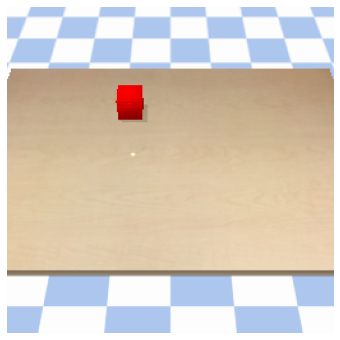

(red cube on table) 1.0
(red cube on_left_side_of table) 0.4195345296565183
(red cube on_right_side_of table) 0.0
(red cube on_far_side_of table) 0.5317160586345229
(red cube on_near_side_of table) 0.0
(red cube in_center_of table) 0.32270302777588966
-----
(blue cube on table) 0.0
(green cube on table) 0.0
(blue sphere on table) 0.0
(green sphere on table) 0.0
(red sphere on table) 0.0
(blue cube on_left_side_of table) 0.0
(green cube on_left_side_of table) 0.0
(blue sphere on_left_side_of table) 0.0
(green sphere on_left_side_of table) 0.0
(red sphere on_left_side_of table) 0.0
(blue cube on_right_side_of table) 0.0
(green cube on_right_side_of table) 0.0
(blue sphere on_right_side_of table) 0.0
(green sphere on_right_side_of table) 0.0
(red sphere on_right_side_of table) 0.0
(blue cube on_far_side_of table) 0.0
(green cube on_far_side_of table) 0.0
(blue sphere on_far_side_of table) 0.0
(green sphere on_far_side_of table) 0.0
(red sphere on_far_side_of table) 0.0
(blue cube on_near_

In [13]:
frame, predicates, false_predicates = create_one((0, 0, 0.5), (4.0, 4.0, 0.0), 100, 0, (256, 256))

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.axis('off')
plt.show()

for p, v in predicates:
    print(p, v)

print("-----")

for p, v in false_predicates:
    print(p, v)

In [15]:
from tqdm.notebook import tqdm

num_samples = 300
num_false_pred = 10
frame_size = (256, 256)

training_set = None
train_X1 = None
train_X2 = None
train_Y = None

training_set = [
    (frame, p.to_one_hot(), np.array([p_value]))
    for frame, predicates, false_predicates in [create_one((0, 0, 0.5), (4.0, 4.0, 0.0), num_false_pred, 0, frame_size) for i in tqdm(range(num_samples))]
    for p, p_value in predicates + false_predicates    
]
random.shuffle(training_set)

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_57424/3820759096.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  obj = random.sample({AtomObject.CUBE, AtomObject.SPHERE}, 1)[0]
/tmp/ipykernel_57424/3820759096.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  color = random.sample({AtomColor.RED, AtomColor.GREEN, AtomColor.BLUE}, 1)[0]


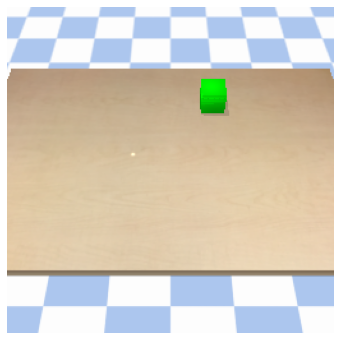

(blue sphere on_left_side_of table)
[0.]


In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(training_set[0][0])
plt.axis('off')
plt.show()

print(AtomPredicate.from_one_hot(training_set[0][1]))
print(training_set[0][2])

In [17]:
print(len(training_set))
for i in range(3):
    print(training_set[0][i].shape)

4800
(256, 256, 3)
(33,)
(1,)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [22]:
frame_inputs = layers.Input(shape=training_set[0][0].shape)
x = layers.experimental.preprocessing.Rescaling(1.0 / 255.0)(frame_inputs)

for size in (8, 8, 8, 16, 32):
    x = layers.Conv2D(size, 3, padding="same", activation='relu')(x)    
    x = layers.MaxPooling2D(2, padding="same")(x)

x = layers.Flatten()(x)
conv_branch_outputs = layers.Dense(64, activation='relu')(x)

predicate_inputs = layers.Input(shape=training_set[0][1].shape)
predicate_branch_outputs = layers.Dense(64, activation='relu')(predicate_inputs)

x = layers.concatenate([conv_branch_outputs, predicate_branch_outputs], axis=-1)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='relu')(x)

model = Model([frame_inputs, predicate_inputs], outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         rescaling[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d[0][0]                     
______________________________________________________________________________________________

2021-10-04 14:19:29.958810: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-04 14:19:29.961326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-04 14:19:29.992436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 14:19:29.992760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M2000M computeCapability: 5.0
coreClock: 1.137GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 74.65GiB/s
2021-10-04 14:19:29.992788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-04 14:19:30.006085: I tensorflow/stream_executor/platform/default/dso_lo

In [23]:
train_X1 = np.stack([x[0] for x in training_set], axis=0)
train_X2 = np.stack([x[1] for x in training_set], axis=0)
train_Y = np.stack([x[2] for x in training_set], axis=0)

np.sum(train_Y) / len(train_Y)

0.1428972742342817

In [24]:
model.fit([train_X1, train_X2], train_Y, epochs=25, validation_split=0.1)

2021-10-04 14:28:22.868509: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 849346560 exceeds 10% of free system memory.
2021-10-04 14:28:23.409357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-04 14:28:23.427702: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2699905000 Hz


Epoch 1/25


2021-10-04 14:28:23.985705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-04 14:28:24.179086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-04 14:28:25.175639: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-04 14:28:25.285725: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - ETA: 0s - loss: 0.0931

2021-10-04 14:28:54.536799: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 94371840 exceeds 10% of free system memory.


135/135 [==============================] - 32s 82ms/step - loss: 0.0931 - val_loss: 0.0866
Epoch 2/25
135/135 [==============================] - 11s 79ms/step - loss: 0.0853 - val_loss: 0.0695
Epoch 3/25
135/135 [==============================] - 11s 80ms/step - loss: 0.0641 - val_loss: 0.0449
Epoch 4/25
135/135 [==============================] - 11s 79ms/step - loss: 0.0476 - val_loss: 0.0375
Epoch 5/25
135/135 [==============================] - 11s 80ms/step - loss: 0.0386 - val_loss: 0.0378
Epoch 6/25
135/135 [==============================] - 11s 81ms/step - loss: 0.0382 - val_loss: 0.0343
Epoch 7/25
135/135 [==============================] - 11s 83ms/step - loss: 0.0311 - val_loss: 0.0235
Epoch 8/25
135/135 [==============================] - 11s 80ms/step - loss: 0.0207 - val_loss: 0.0188
Epoch 9/25
135/135 [==============================] - 11s 80ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 10/25
135/135 [==============================] - 11s 79ms/step - loss: 0.0072 - val_los

In [100]:
model.optimizer.learning_rate = 1e-4
model.fit([train_X1, train_X2], train_Y, epochs=10, validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 6s 45ms/step - loss: 1.1825e-04 - val_loss: 0.0011
Epoch 2/10
135/135 [==============================] - 6s 43ms/step - loss: 1.1034e-04 - val_loss: 0.0011
Epoch 3/10
135/135 [==============================] - 6s 43ms/step - loss: 1.0591e-04 - val_loss: 0.0012
Epoch 4/10
135/135 [==============================] - 6s 43ms/step - loss: 1.0444e-04 - val_loss: 0.0010
Epoch 5/10
135/135 [==============================] - 6s 42ms/step - loss: 9.8189e-05 - val_loss: 0.0010
Epoch 6/10
135/135 [==============================] - 6s 43ms/step - loss: 9.9547e-05 - val_loss: 0.0011
Epoch 7/10
135/135 [==============================] - 6s 43ms/step - loss: 9.7685e-05 - val_loss: 0.0011
Epoch 8/10
135/135 [==============================] - 6s 43ms/step - loss: 8.9721e-05 - val_loss: 0.0010
Epoch 9/10
135/135 [==============================] - 6s 43ms/step - loss: 9.1007e-05 - val_loss: 0.0010
Epoch 10/10
135/135 [==============================] - 

In [ ]:
for p, t in zip(model.predict([train_X1, train_X2]), train_Y):
    print(p, t)

In [25]:
probes = np.vstack([
    AtomPredicate(relation, obj, obj_color, AtomObject.TABLE, AtomColor.NO_COLOR).to_one_hot()
    for relation in set(AtomRelation.__members__.values()) - {AtomRelation.NEAR}
    for obj in {AtomObject.CUBE, AtomObject.SPHERE}
    for obj_color in {AtomColor.RED, AtomColor.BLUE, AtomColor.GREEN}
])

In [26]:
probes.shape

(36, 33)

/tmp/ipykernel_57424/3820759096.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  obj = random.sample({AtomObject.CUBE, AtomObject.SPHERE}, 1)[0]
/tmp/ipykernel_57424/3820759096.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  color = random.sample({AtomColor.RED, AtomColor.GREEN, AtomColor.BLUE}, 1)[0]


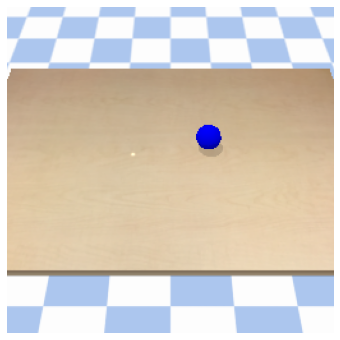

(blue sphere on table) 0.8537586
(blue sphere on_right_side_of table) 0.390926
(blue sphere in_center_of table) 0.5611532


In [33]:
test_frame, truth, _ = create_one((0, 0, 0.5), (4.0, 4.0, 0.0), 0, 0, frame_size)

prediction = model.predict([
    np.broadcast_to(test_frame, (len(probes), *test_frame.shape)),
    probes,
])

plt.figure(figsize=(6, 6))
plt.imshow(test_frame)
plt.axis('off')
plt.show()

# for p, v in truth:
#     print(p, v)
# print("---")

for probe, pred in zip(probes, prediction):
    if pred[0] > 0.3:
        print(AtomPredicate.from_one_hot(probe), pred[0])